In [47]:
from robobrowser import RoboBrowser
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR
from keras.models import model_from_json
import numpy as np
import statsmodels.api as sm
import time
import pickle

### Pre-set

In [48]:
def turnFloat(x):
    x = x.replace('.', '').replace(',', '.')
    return float(x)

def into(item):
    return item[0]

def numerize(num):
    if str(num).lower() == 'nan':
        return 0
    else:
        return num

today = time.localtime()
day = str(today.tm_mday)
if len(day) == 1:
    day = '0' + day
mon = str(today.tm_mon)
if len(mon) == 1:
    mon = '0' + mon
year = str(today.tm_year)[-2:]
date = f'{day}/{mon}/{year}'

### Criando banco de dados

In [6]:
hist = {
    'date': [],
    'val': []
}

browser = RoboBrowser(parser = 'html.parser')
for i in tqdm(range(60)):
    url = f'https://br.advfn.com/bolsa-de-valores/coin/BTCUSD/historico/mais-dados-historicos?current={i}&Date1=01/01/90&Date2=01/02/20'
    try:
        browser.open(url)
    except:
        break
    else:
        rows = browser.find_all(class_ = 'result')
        for row in rows:
            info = row.find_all('td')

            date = info[0].text
            val = turnFloat(info[1].text)

            hist['date'].append(date)
            hist['val'].append(val)
        
hist['date'] = hist['date'][::-1]
hist['val'] = hist['val'][::-1]

df = pd.DataFrame(hist)
#df.to_csv('data.csv', index = False)
df.tail()

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [02:36<00:00,  2.60s/it]


,date,val
3546,28 Jan 2020,9368.5
3547,29 Jan 2020,9321.0
3548,30 Jan 2020,9498.0
3549,31 Jan 2020,9330.0
3550,01 Fev 2020,9386.5


### Atualizando banco de dados

In [49]:
hist = {
    'date': [],
    'val': []
}

df = pd.read_csv('data.csv')

browser = RoboBrowser(parser = 'html.parser')
skip = False
for i in range(61):
    url = f'https://br.advfn.com/bolsa-de-valores/coin/BTCUSD/historico/mais-dados-historicos?current={i}&Date1=01/01/90&Date2={date}'
    try:
        browser.open(url)
    except:
        break
    else:
        rows = browser.find_all(class_ = 'result')
        for row in rows:
            info = row.find_all('td')
            date = info[0].text
            if date not in df['date'].values:
                val = turnFloat(info[1].text)
                hist['date'].append(date)
                hist['val'].append(val)
            else:
                skip = True
                break
    if skip:
        break
        
hist['date'] = hist['date'][::-1]
hist['val'] = hist['val'][::-1]

df = pd.concat([df, pd.DataFrame(hist)], ignore_index = True)
df.to_csv('data.csv', index = False)

df.tail()

,date,val
3567,18 Fev 2020,10200.5
3568,19 Fev 2020,9630.0
3569,20 Fev 2020,9614.5
3570,21 Fev 2020,9705.5
3571,22 Fev 2020,9671.0


### Gráfico recente

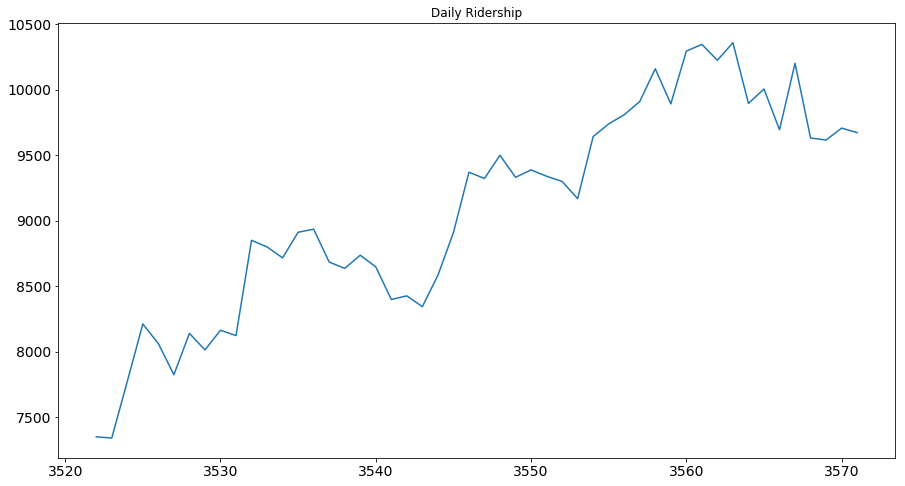

In [50]:
amost = 50
df[-amost:].val.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
plt.show()

In [51]:
d = 0
vals = df.val
last = vals.iloc[-(2+d)]
now = vals.iloc[-(1+d)]
var = round((now - last)/last, 4)
print(f'Variação: {var}')

Variação: -0.0036


### Testes

C:\Users\thale\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


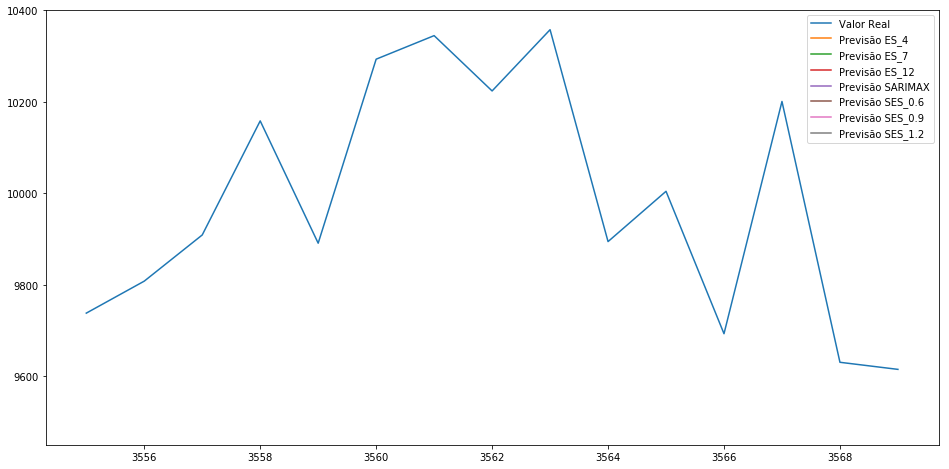

In [25]:
n_total = len(df)
amost = 15
n_test = 1
n_pred = n_test

pred = {}

null = np.array([None for _ in range(n_total - n_test)])

sp = 4
name = f'ES_{sp}'
fit1 = ExponentialSmoothing(np.asarray(df['val'][:-n_test]) ,seasonal_periods=sp ,trend='add', seasonal='add',).fit()
forecast = fit1.forecast(n_pred)
pred[name] = np.concatenate((null, forecast))
plt.figure(figsize=(16,8))
plt.plot(df[-amost:]['val'], label = 'Valor Real')
plt.plot(pred[name], label = f'Previsão {name}')

sp = 7
name = f'ES_{sp}'
fit1 = ExponentialSmoothing(np.asarray(df['val'][:-n_test]) ,seasonal_periods=sp ,trend='add', seasonal='add',).fit()
forecast = fit1.forecast(n_pred)
pred[name] = np.concatenate((null, forecast))
plt.plot(pred[name], label = f'Previsão {name}')

sp = 12
name = f'ES_{sp}'
fit1 = ExponentialSmoothing(np.asarray(df['val'][:-n_test]) ,seasonal_periods=sp ,trend='add', seasonal='add',).fit()
forecast = fit1.forecast(n_pred)
pred[name] = np.concatenate((null, forecast))
plt.plot(pred[name], label = f'Previsão {name}')

name = f'SARIMAX'
fit1 = sm.tsa.statespace.SARIMAX(df['val'][:-n_test], order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
forecast = fit1.forecast(n_pred)
pred[name] = np.concatenate((null, forecast))
plt.plot(pred[name], label = f'Previsão {name}')

sl = 0.6
name = f'SES_{sl}'
fit1 = SimpleExpSmoothing(np.asarray(df['val'][:-n_test])).fit(smoothing_level=sl,optimized=False)
forecast = fit1.forecast(n_pred)
pred[name] = np.concatenate((null, forecast))
plt.plot(pred[name], label = f'Previsão {name}')

sl = 0.9
name = f'SES_{sl}'
fit1 = SimpleExpSmoothing(np.asarray(df['val'][:-n_test])).fit(smoothing_level=sl,optimized=False)
forecast = fit1.forecast(n_pred)
pred[name] = np.concatenate((null, forecast))
plt.plot(pred[name], label = f'Previsão {name}')

sl = 1.2
name = f'SES_{sl}'
fit1 = SimpleExpSmoothing(np.asarray(df['val'][:-n_test])).fit(smoothing_level=sl,optimized=False)
forecast = fit1.forecast(n_pred)
pred[name] = np.concatenate((null, forecast))
plt.plot(pred[name], label = f'Previsão {name}')

#eps = 400
#name = f'Sequential_{eps}'
#model = Sequential()
#model.add(Dense(24, input_shape = (1,), activation='relu'))
#model.add(Dense(12, activation='relu'))
#model.add(Dense(8, activation='relu'))
#model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam')
#trainX, trainY = df['val'][:-n_test-1].values, df['val'][1: -n_test].values
#testX, testY = df['val'][-n_test-1:].values, df['val'][-n_test:].values
#model.fit(trainX, trainY, epochs=eps, batch_size=2, verbose=2)
#pred[name] = np.concatenate((null, model.predict(testX)[:,0]))
#plt.plot(pred[name], label = f'Previsão {name}')

plt.legend(loc='best')
plt.show()

In [24]:
n = n_total - n_test -1
l = df['val'][n]
f = df['val'][n+1]
v = round((f - l)/l, 4)
preds = []
rights = []
wrongs = []
print(f'Presente: {l}')
print(f'Futuro: {f}')
print(f'Variação: {v}\n')
for k in pred.keys():
    p = pred[k][n+1]
    preds.append(p)
    right = (p > l) == (f > l)
    if right:
        rights.append(p)
    else:
        wrongs.append(p)
    print(f'{k}: {p} --- {right}')

sd = numerize(round(np.std(preds), 3))
r_sd = numerize(round(np.std(rights), 3))
w_sd = numerize(round(np.std(wrongs), 3))
r_len = numerize(round(len(rights), 3))
w_len = numerize(round(len(wrongs), 3))
r_dif = numerize(round(abs(np.mean(rights) - l), 3))
w_dif = numerize(round(abs(np.mean(wrongs) - l), 3))

print(f'\nDesvio Padrão: {sd}')
print(f'Desvio Padrão de acertos: {r_sd}')
print(f'Desvio Padrão de erros: {w_sd}')
print(f'Número de acertos: {r_len}')
print(f'Número de erros: {w_len}')
print(f'Distância de acertos: {r_dif}')
print(f'Distância de erros: {w_dif}')

sd = np.std(preds)
u_sd = np.std(ups)
d_sd = np.std(downs)
u_len = len(ups)
d_len = len(downs)
u_dif = abs(np.mean(ups) - l)
d_dif = abs(np.mean(downs) - l)

NameError: name 'n_test' is not defined

### Aplicação

C:\Users\thale\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


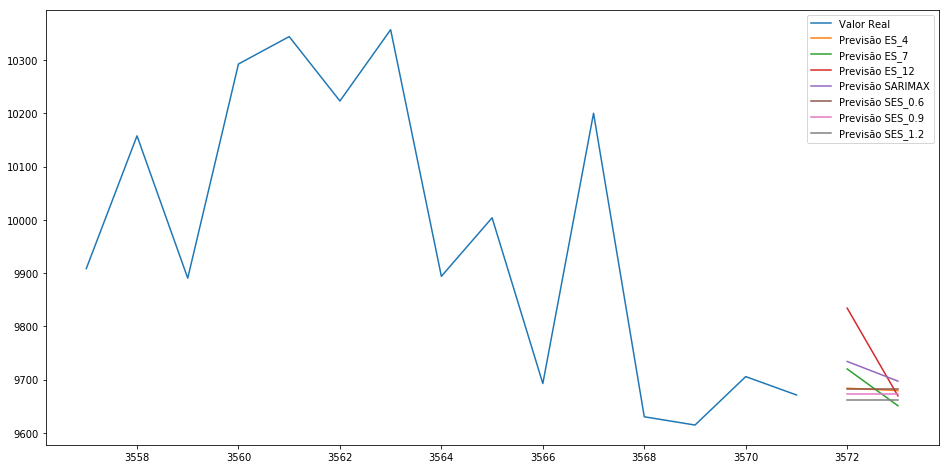

In [52]:
n_total = len(df)
amost = 15
n_pred = 2

pred = {}

null = np.array([None for _ in range(n_total)])

sp = 4
name = f'ES_{sp}'
fit1 = ExponentialSmoothing(np.asarray(df['val']) ,seasonal_periods=sp ,trend='add', seasonal='add',).fit()
forecast = fit1.forecast(n_pred)
pred[name] = np.concatenate((null, forecast))
plt.figure(figsize=(16,8))
plt.plot(df[-amost:]['val'], label = 'Valor Real')
plt.plot(pred[name], label = f'Previsão {name}')

sp = 7
name = f'ES_{sp}'
fit1 = ExponentialSmoothing(np.asarray(df['val']) ,seasonal_periods=sp ,trend='add', seasonal='add',).fit()
forecast = fit1.forecast(n_pred)
pred[name] = np.concatenate((null, forecast))
plt.plot(pred[name], label = f'Previsão {name}')

sp = 12
name = f'ES_{sp}'
fit1 = ExponentialSmoothing(np.asarray(df['val']) ,seasonal_periods=sp ,trend='add', seasonal='add',).fit()
forecast = fit1.forecast(n_pred)
pred[name] = np.concatenate((null, forecast))
plt.plot(pred[name], label = f'Previsão {name}')

name = f'SARIMAX'
fit1 = sm.tsa.statespace.SARIMAX(df['val'], order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
forecast = fit1.forecast(n_pred)
pred[name] = np.concatenate((null, forecast))
plt.plot(pred[name], label = f'Previsão {name}')

sl = 0.6
name = f'SES_{sl}'
fit1 = SimpleExpSmoothing(np.asarray(df['val'])).fit(smoothing_level=sl,optimized=False)
forecast = fit1.forecast(n_pred)
pred[name] = np.concatenate((null, forecast))
plt.plot(pred[name], label = f'Previsão {name}')

sl = 0.9
name = f'SES_{sl}'
fit1 = SimpleExpSmoothing(np.asarray(df['val'])).fit(smoothing_level=sl,optimized=False)
forecast = fit1.forecast(n_pred)
pred[name] = np.concatenate((null, forecast))
plt.plot(pred[name], label = f'Previsão {name}')

sl = 1.2
name = f'SES_{sl}'
fit1 = SimpleExpSmoothing(np.asarray(df['val'])).fit(smoothing_level=sl,optimized=False)
forecast = fit1.forecast(n_pred)
pred[name] = np.concatenate((null, forecast))
plt.plot(pred[name], label = f'Previsão {name}')

#eps = 400
#name = f'Sequential_{eps}'
#model = Sequential()
#model.add(Dense(24, input_shape = (1,), activation='relu'))
#model.add(Dense(12, activation='relu'))
#model.add(Dense(8, activation='relu'))
#model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam')
#trainX, trainY = df['val'][:-1].values, df['val'][1:].values
#testX, testY = df['val'][-1:].values, df['val'].values
#model.fit(trainX, trainY, epochs=eps, batch_size=2, verbose=2)
#pred[name] = np.concatenate((null, model.predict(testX)[:,0]))
#plt.plot(pred[name], label = f'Previsão {name}')

plt.legend(loc='best')
plt.show()

In [53]:
hist = {
    'ES_4': [],
    'ES_7': [],
    'ES_12': [],
    'SARIMAX': [],
    'SES_0.6': [],
    'SES_0.9': [],
    'SES_1.2': [],
    'DP': [],
    'DP_U': [],
    'DP_D': [],
    'NUM_U': [],
    'NUM_D': [],
    'DIST_U': [],
    'DIST_D': [],
}

n = n_total
l = df['val'][n-1]

preds = []
ups = []
downs = []
print(f'Presente: {l}\n')

for k in pred.keys():
    p = pred[k][n]
    preds.append(p)
    up = (p > l)
    if up:
        ups.append(p)
        hist[k].append(1)
    else:
        downs.append(p)
        hist[k].append(0)
    print(f'{k}: {p} --- {up}')

sd = numerize(round(np.std(preds), 3))
u_sd = numerize(round(np.std(ups), 3))
d_sd = numerize(round(np.std(downs), 3))
u_len = numerize(round(len(ups), 3))
d_len = numerize(round(len(downs), 3))
u_dif = numerize(round(abs(np.mean(ups) - l), 3))
d_dif = numerize(round(abs(np.mean(downs) - l), 3))

hist['DP'].append(sd)
hist['DP_U'].append(u_sd)
hist['DP_D'].append(d_sd)
hist['NUM_U'].append(u_len)
hist['NUM_D'].append(d_len)
hist['DIST_U'].append(u_dif)
hist['DIST_D'].append(d_dif)

info = pd.DataFrame(hist)

print(f'\nDesvio Padrão: {sd}')
print(f'Desvio Padrão de crescentes: {u_sd}')
print(f'Desvio Padrão de decrescentes: {d_sd}')
print(f'Número de crescentes: {u_len}')
print(f'Número de decrescentes: {d_len}')
print(f'Distância de crescentes: {u_dif}')
print(f'Distância de decrescentes: {d_dif}')

Presente: 9671.0

ES_4: 9683.664089280443 --- True
ES_7: 9719.877499825046 --- True
ES_12: 9834.149877220934 --- True
SARIMAX: 9733.966636061821 --- True
SES_0.6: 9682.003908903716 --- True
SES_0.9: 9673.607775012206 --- True
SES_1.2: 9661.433970707312 --- False

Desvio Padrão: 55.027
Desvio Padrão de crescentes: 54.974
Desvio Padrão de decrescentes: 0.0
Número de crescentes: 6
Número de decrescentes: 1
Distância de crescentes: 50.212
Distância de decrescentes: 9.566


In [57]:
nvers = 166
name = f'gradient_{nvers}s'
model = pickle.load(open(f'{name}.sav', 'rb'))
print(f'Análise de resultados por {name}:\n')

probs = model.predict_proba(info)[0]
up_prob = round(probs[1], 2)
down_prob = round(probs[0], 2)
if up_prob > 0.7:
    print('Probabilidade de ALTA para amanhã:', up_prob)
    print('Ação: COMPRAR')

elif up_prob > 0.4:
    print('Probabilidade incerta, com chance para alta de:', up_prob)
    print('Ação: MANTER')
    
else:
    print('Probabilidade de BAIXA para amanhã:', down_prob)
    print('Ação: VENDER.')

Análise de resultados por gradient_166s:

Probabilidade de BAIXA para amanhã: 0.99
Ação: VENDER.


In [58]:
nvers = 166
name = f'sequential_{nvers}s'
print(f'Analise de resultados por {name}:\n')
# load json and create model
json_file = open(f'{name}.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights(f'{name}.h5')

probs = model.predict_proba(info)[0]
up_prob = round(probs[1], 2)
down_prob = round(probs[0], 2)
if up_prob > 0.7:
    print('Probabilidade de ALTA para amanhã:', up_prob)
    print('Ação: COMPRAR')
    
elif up_prob > 0.4:
    print('Probabilidade incerta, com chance para alta de:', up_prob)
    print('Ação: MANTER')
    
else:
    print('Probabilidade de BAIXA para amanhã:', down_prob)
    print('Ação: VENDER.')

Analise de resultados por sequential_166s:

Probabilidade incerta, com chance para alta de: 0.52
Ação: MANTER


In [61]:
print(f'{up_prob}')

0.5199999809265137


In [66]:
print(round(probs[1], 2))

0.52
